Using TensorFlow backend.


C:\Users\herma\Apps\master-thesis\src\utils
C:\Users\herma\Apps\master-thesis
Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 13885 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 146747 rows

Model mlpd 1

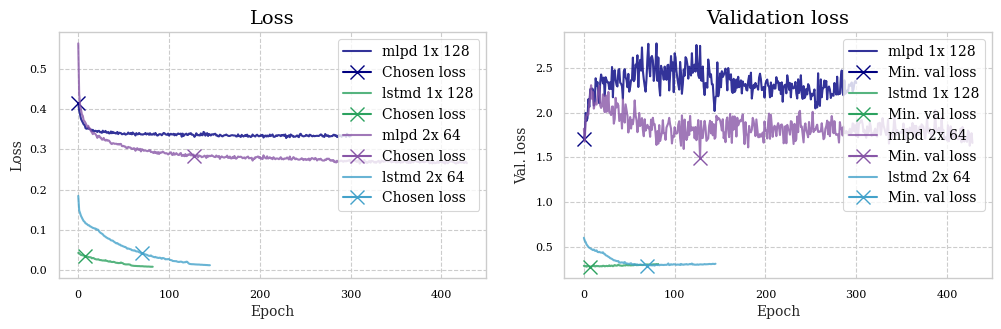

Model prediction scores
+---------------------+-------------+------------+
|        Model        | Train score | Test score |
+---------------------+-------------+------------+
|     mlpd 1x 128     |    0.3553   |  -1.1015   |
|     lstmd 1x 128    |    0.7413   |  -1.0049   |
|      mlpd 2x 64     |    0.5006   |  -1.2382   |
|     lstmd 2x 64     |    0.7256   |  -1.0194   |
| lstm + mlp ensemble |    0.7948   |  -0.9503   |
|       linear r      |    0.4405   |  -0.9779   |
+---------------------+-------------+------------+


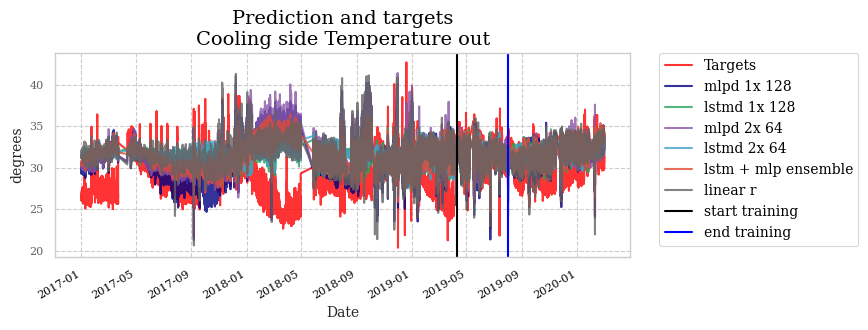

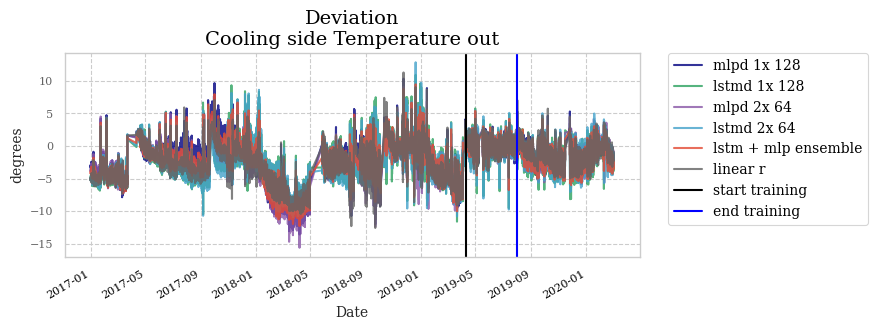

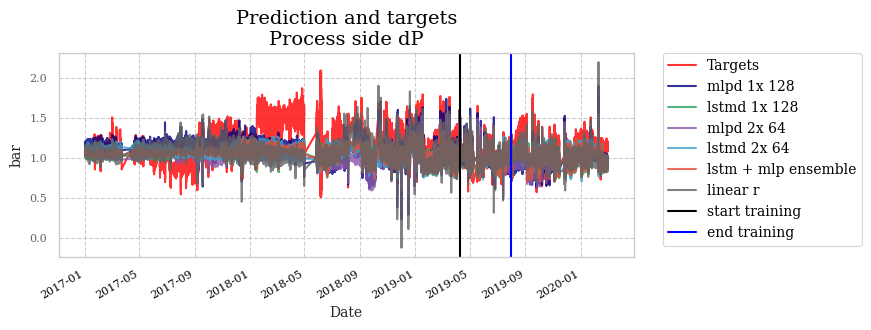

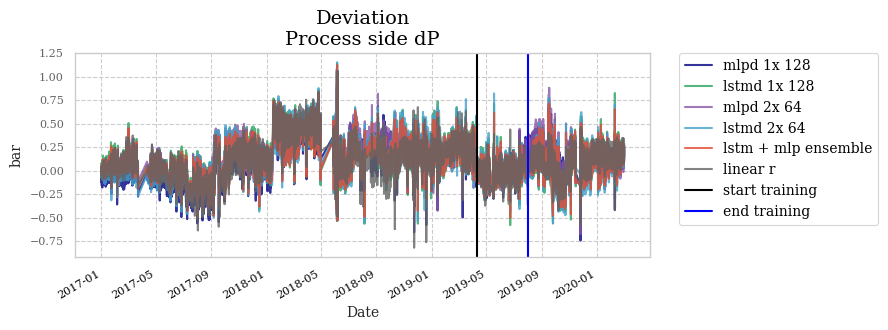

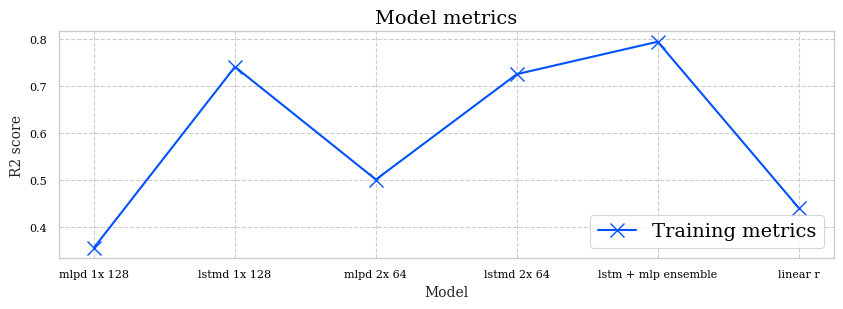

In [1]:
# %load example_G_basic.py
import src.core as mlApi

# 1. Define dataset specifics

# File path to dataset .csv file
filename = "../master-thesis-db/datasets/G/data_10min.csv"

# List of columns on form ['name', 'desc', 'unit']
columns = [
	['PDI0064', 'Process side dP', 'bar'],
	['TI0066', 'Process side Temperature out','degrees'],
	['TZI0012', 'Process side Temperature in', 'degrees'],
	['FI0010', 'Process side flow rate', 'MSm^3/d(?)'],
	['TT0025', 'Cooling side Temperature in', 'degrees'],
	['TT0026', 'Cooling side Temperature out', 'degrees'],
	['PI0001', 'Cooling side Pressure in', 'barG'],
	['FI0027', 'Cooling side flow rate', 'MSm^3/d(?)'],
	['TIC0022U', 'Cooling side valve opening', '%'],
	['PDT0024', 'Cooling side dP', 'bar'],
]

# List of column names to ignore completely
irrelevantColumns = [
	'PI0001',
	'FI0027',
	'TIC0022U',
	'PDT0024',
]

# List of column names used a targets
targetColumns = [
	'TT0026',
    'PDI0064',
]

# List of training periods on form ['start', 'end']
traintime = [
	["2019-04-10 00:00:00", "2019-08-01 00:00:00"]
]

# Testing period, recommended: entire dataset
testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

# 2. Initiate and divide data

df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models

mlpd_1x_128 = mlApi.MLP('mlpd 1x 128', layers=[128], dropout=0.2, epochs=1000)
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128', layers=[128], dropout=0.2, recurrentDropout=0.2, training=False, epochs=500, batchSize=128*2*2, enrolWindow=16)

mlpd_2x_64 = mlApi.MLP('mlpd 2x 64', layers=[64, 64], dropout=0.2, epochs=1000)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=False, epochs=500, batchSize=128*2*2, enrolWindow=16)
linear_r = mlApi.Linear_Regularized('linear r')

ensemble = mlApi.Ensemble('lstm + mlp ensemble', [lstmd_1x_128, mlpd_1x_128])

modelList = [
	mlpd_1x_128,
	lstmd_1x_128,
	mlpd_2x_64,
	lstmd_2x_64,
    ensemble,
	linear_r,
]

# 4. Initiate and train models

# Define whether to retrain models or not
retrain=False

mlApi.initModels(modelList)
mlApi.trainModels(retrain)
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
	plot=True,
	interpol=False,
)

